In [2]:
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
def draw_yolo_bounding_box(img, x_center, y_center, width, height):
    """
    Draws a bounding box on the image using YOLO format coordinates.

    Parameters:
    - img: The image on which to draw the bounding box.
    - x_center, y_center, width, height: YOLO format coordinates (normalized).

    Returns:
    - img: The image with the bounding box drawn.
    """
    img_height, img_width = img.shape[:2]
    
    # Convert normalized coordinates to absolute coordinates
    x_center_abs = float(x_center) * img_width
    y_center_abs = float(y_center) * img_height
    width_abs = float(width) * img_width
    height_abs = float(height) * img_height
    
    # Calculate top-left and bottom-right coordinates
    x1 = int(x_center_abs - width_abs / 2)
    y1 = int(y_center_abs - height_abs / 2)
    x2 = int(x_center_abs + width_abs / 2)
    y2 = int(y_center_abs + height_abs / 2)
    print(x1, y1, x2, y2)
    
    # Draw the bounding box on the image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return img


def load_yolo_annotations(annotation_path) -> list:
    """
    Loads YOLO annotations from a text file.

    Parameters:
    - annotation_path: Path to the annotation file.

    Returns:
    - annotations: List of YOLO annotations.
    """
    annotations = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = parts
                annotations.append((class_id, x_center, y_center, width, height))
    return annotations

536 402 896 1296


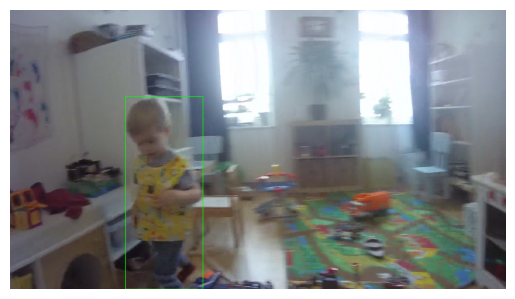

In [4]:
# Paths to the image and annotation file
frame = 'quantex_at_home_id255237_2022_05_08_03_004530'
image_path_01 = f'../../../ProcessedData/yolo/images/train/{frame}.jpg'  
image_path_02 = f'../../../ProcessedData/yolo/images/val/{frame}.jpg'  
annotation_path_1 = f'../../../ProcessedData/yolo/labels/train/{frame}.txt'  
annotation_path_2 = f'../../../ProcessedData/yolo/labels/val/{frame}.txt'  

if os.path.exists(annotation_path_1):
    annotation_path = annotation_path_1
elif os.path.exists(annotation_path_2):
    annotation_path = annotation_path_2
else:
    raise FileNotFoundError(f"Annotation file not found in either directory for frame: {frame}")

if os.path.exists(image_path_01):
    image_path = image_path_01
elif os.path.exists(image_path_02):
    image_path = image_path_02
else:
    raise FileNotFoundError(f"Image file not found in either directory for frame: {frame}")
# Load the image
img = cv2.imread(image_path)
annotations = load_yolo_annotations(annotation_path)

# Draw bounding boxes for all annotations
for annotation in annotations:
    class_id, x_center, y_center, width, height = annotation
    img = draw_yolo_bounding_box(img, x_center, y_center, width, height)

# Convert BGR image to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [5]:
import os
import random
import shutil
from pathlib import Path

def copy_subset(src_img_dir, src_label_dir, dst_img_dir, dst_label_dir, percentage=0.1):
    # Get list of image files
    img_files = list(Path(src_img_dir).glob('*.jpg'))
    total_files = len(img_files)
    subset_size = int(total_files * percentage)
    
    # Select a random subset of image files
    selected_images = random.sample(img_files, subset_size)
    
    # Create destination directories if they don't exist
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_label_dir, exist_ok=True)

    for img_file in selected_images:
        # Copy image file
        shutil.copy(img_file, dst_img_dir)
        
        # Find corresponding label file
        label_file = src_label_dir / (img_file.stem + '.txt')  # Assuming labels are .txt files
        
        # Copy label file if it exists
        if label_file.exists():
            shutil.copy(label_file, dst_label_dir)


In [6]:
# Define paths
base_dir = Path('../../../ProcessedData/yolo')  # Change to your base directory
new_base_dir = Path('../../../ProcessedData/yolo_small')  # Change to your destination directory

# Define source and destination directories
src_train_img_dir = base_dir / 'images/train'
src_train_label_dir = base_dir / 'labels/train'
dst_train_img_dir = new_base_dir / 'images/train'
dst_train_label_dir = new_base_dir / 'labels/train'

src_val_img_dir = base_dir / 'images/val'
src_val_label_dir = base_dir / 'labels/val'
dst_val_img_dir = new_base_dir / 'images/val'
dst_val_label_dir = new_base_dir / 'labels/val'

# Copy subset of data (10% in this case)
copy_subset(src_train_img_dir, src_train_label_dir, dst_train_img_dir, dst_train_label_dir, percentage=0.1)
copy_subset(src_val_img_dir, src_val_label_dir, dst_val_img_dir, dst_val_label_dir, percentage=0.1)
